In [ ]:
# EEG preprocessing script - a translation from EEGLAB to MNE-Python
# Mikkel Alcalá-Haug, 2025
# Phd Candidate, NTNU
# AI-Psychology & Biosignals
#SynCoRE Lab
#=====================================
# THE FOLLOWING SCRIPT IS UNDER DEVELOPMENT AND MAY CONTAIN INCOMPLETE OR EXPERIMENTAL CODE SNIPPETS.
# PLEASE REVIEW AND TEST EACH SECTION CAREFULLY BEFORE USE IN A PRODUCTION ENVIRONMENT.
# SOME PARTS IS MISSING AND NEEDS TO BE FILLED IN, HENCE THE PLACEHOLDERS (_) THROUGHOUT THE SCRIPT.
#=====================================


In [ ]:
#=== LIBRARY AND PACKAGE IMPORTS ===
from pathlib import Path
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import ICA
from mne.annotations import Annotations 
import math
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from datetime import datetime
import json
import re
import os
from collections import defaultdict
from collections import Counter
import matplotlib as mpl
from matplotlib_inline.backend_inline import set_matplotlib_formats
from pyprep.prep_pipeline import PrepPipeline
from mne_icalabel import label_components
from collections import OrderedDict
import shutil
import copy 
import mne_icalabel
from mne_icalabel.iclabel import iclabel_label_components




In [ ]:
# ==================== SET CONFIG ====================
MFF_PATH = Path("_")

# --- Montage ---
USE_CSV_MONTAGE = True
CSV_MONTAGE_PATH = Path("_")  

In [ ]:
# === SET PARAMETERS ===
# --- CONFIG: AUX / EOG -----------------------------------
AUX_LABS = []
print("AUX_LABS configured as:", AUX_LABS)

# Eye-ring channels (EEG electrodes close to eyes)
EYE_LABS = []
print("EYE_LABS (eye-ring EEG channels):", EYE_LABS)

# One EEG channel to use as EOG regressor for ICA blink detection
EOG_CH = None
print("Initial EOG_CH (EEG channel used as EOG regressor):", EOG_CH)

# Filters
HP_ICA = _   # Hz 
LP     = _   # Hz

# Clean Rawdata analog
FLATLINE_SEC = _
CHANNEL_CRIT = _
ASR_ENABLED  = False


OUT_DIR       = MFF_PATH.parent
BASE          = MFF_PATH.with_suffix("").name
REPORT_TXT    = OUT_DIR / f"{BASE}_preproc_report.txt"
CLEAN_FIF     = OUT_DIR / f"{BASE}_Clean-raw.fif"
CLEAN_FIF_ERP = OUT_DIR / f"{BASE}_Clean_0p25-25-raw.fif"
REPORT_JSON   = OUT_DIR / f"{BASE}_preproc_meta.json"


In [ ]:
# === Blink inspection helper ===
def plot_blink_candidates(raw, picks, tmin, tmax):
    """
    Quick stacked plot of candidate blink channels (µV) using matplotlib.

    raw  : Raw object
    picks: list of channel names
    tmin/tmax: time window in seconds
    """
    ch_names = [ch for ch in picks if ch in raw.ch_names]
    if not ch_names:
        print("No candidate channels found in raw.")
        print("Available channels example:", raw.ch_names[:20])
        return

    sfreq = raw.info["sfreq"]
    start = int(tmin * sfreq)
    stop  = int(tmax * sfreq)

    data, times = raw.get_data(
        picks=ch_names,
        start=start,
        stop=stop,
        return_times=True,
    )  

    # Convert to µV and remove DC offset
    data_uv = data * 1e6
    data_uv = data_uv - data_uv.mean(axis=1, keepdims=True)

    n_ch    = len(ch_names)
    max_ptp = np.ptp(data_uv, axis=1).max()
    spacing = max(50.0, max_ptp * 1.2)

    offsets = np.arange(n_ch) * spacing

    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(ch_names):
        plt.plot(times, data_uv[i] + offsets[i], linewidth=0.7, label=ch)

    plt.yticks(offsets, ch_names)
    plt.xlabel("Time (s)")
    plt.title(f"Candidate blink channels {tmin:.1f}–{tmax:.1f} s")
    plt.grid(True, axis="x", linestyle=":", linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
# === LOAD, NORMALIZE, REPORT (new API) ===
raw = mne.io.read_raw_egi(MFF_PATH, preload=True, verbose="ERROR")

# --- Normalize Cz on RAW (REF CZ -> Cz) and ensure EEG *before anything else* ---
cz_alias = next((ch for ch in raw.ch_names
                 if re.fullmatch(r'\s*(REF\s*)?CZ\s*', ch, flags=re.I)), None)
if cz_alias and cz_alias != "Cz":
    raw.rename_channels({cz_alias: "Cz"})
    print(f"Renamed '{cz_alias}' → 'Cz'")
if "Cz" in raw.ch_names:
    raw.set_channel_types({"Cz": "eeg"})

# --- Exclude only AUX leads  ---
aux_present = [ch for ch in AUX_LABS if ch in raw.ch_names]
if aux_present:
    raw.set_channel_types({ch: 'misc' for ch in aux_present})
    print("AUX channels set to 'misc':", aux_present)

# --- Now compute EEG list (post-normalization) ---
ch_types  = raw.get_channel_types()
eeg_idx   = [i for i, t in enumerate(ch_types) if t == "eeg"]
eeg_names = [raw.ch_names[i] for i in eeg_idx]

# --- Detect Cz-like names (for logging only) ---
cz_pattern = re.compile(r'(^|\b)cz(\b|$)', flags=re.IGNORECASE)
cz_names   = [ch for ch in raw.ch_names if cz_pattern.search(ch)]
cz_count   = len(cz_names)

# --- Sampling info & report ---
fs  = raw.info["sfreq"]
dur = raw.n_times / fs
print(f"Loaded: {MFF_PATH.name}")
print(f"Total channels in file: {len(raw.ch_names)}")
print(f"EEG channels only: {len(eeg_names)}  |  Cz: {cz_count}  |  Fs: {fs:.2f} Hz  |  Duration: {dur:.1f} s")
if cz_names:
    print("Cz-like channel(s) detected:", cz_names)

# --- Working EEG-only copy for next steps (Cz retained) ---
raw_eeg = raw.copy().pick(['eeg'])
print(f"Now operating on EEG-only Raw with {len(raw_eeg.ch_names)} channels (Cz retained).")
print("First 15 EEG ch (raw names):", raw_eeg.ch_names[:15])


In [ ]:
# Print and save trigger summary
def summarize_events(raw):
    """
    Return a DataFrame with per-trigger summary:
      Trigger | Count | FirstTime_s | LastTime_s
    Prefer annotations; else fall back to a stim channel if present.
    """
    # 1) Prefer annotations 
    if len(raw.annotations):
        events, event_id = mne.events_from_annotations(raw, verbose=False)

    else:
        # 2) Fall back to a stim channel if one exists 
        stim_candidates = [ch for ch in raw.ch_names
                           if ('STI' in ch) or ('Stim' in ch) or ('STIM' in ch)]
        stim_ch = stim_candidates[0] if len(stim_candidates) else None
        if stim_ch is None:
            # nothing to parse -> empty table
            return pd.DataFrame(columns=["Trigger", "Count", "FirstTime_s", "LastTime_s"])

        events = mne.find_events(raw, stim_channel=stim_ch, shortest_event=1, verbose=False)
        uniq = np.unique(events[:, 2])
        event_id = {str(v): int(v) for v in uniq}

    if events.size == 0:
        return pd.DataFrame(columns=["Trigger", "Count", "FirstTime_s", "LastTime_s"])

    sfreq = raw.info["sfreq"]
    times_s = events[:, 0] / sfreq
    codes = events[:, 2]
    inv = {v: k for k, v in event_id.items()}

    rows = []
    for code in np.unique(codes):
        m = codes == code
        rows.append({
            "Trigger": inv.get(code, str(code)),
            "Count": int(m.sum()),
            "FirstTime_s": float(times_s[m].min()),
            "LastTime_s": float(times_s[m].max()),
        })
    df = pd.DataFrame(rows).sort_values(
        ["Count", "Trigger"], ascending=[False, True], ignore_index=True
    )
    return df

# Build & save summary (same folder as the .mff)
summary_df = summarize_events(raw)

# meta numbers
unique_types = summary_df["Trigger"].nunique() if not summary_df.empty else 0
tt255_count = int(summary_df.loc[summary_df["Trigger"] == "TT255", "Count"].sum()) if not summary_df.empty else 0
non_tt255_total = int(summary_df.loc[summary_df["Trigger"] != "TT255", "Count"].sum()) if not summary_df.empty else 0

meta_df = pd.DataFrame([
    {"Trigger": "[META] UniqueEventTypes", "Count": unique_types, "FirstTime_s": "", "LastTime_s": ""},
    {"Trigger": "[META] NonTT255_Total",   "Count": non_tt255_total, "FirstTime_s": "", "LastTime_s": ""},
    {"Trigger": "[META] TT255_Total",      "Count": tt255_count, "FirstTime_s": "", "LastTime_s": ""},
])

final_df = pd.concat([meta_df, summary_df], ignore_index=True)
out_csv = MFF_PATH.parent / f"{MFF_PATH.stem}_trigger_summary.csv"
final_df.to_csv(out_csv, index=False)

print(
    f"Unique event types: {unique_types}. \n"
    f"Non-TT255 total:   {non_tt255_total}\n"
    f"TT255 total:       {tt255_count}\n"
    f"Saved full summary to: {out_csv}"
)

In [ ]:
# === Apply CSV montage to raw_eeg (auto sep + units) ===
def make_montage_from_csv(csv_path: Path, raw_for_map: mne.io.BaseRaw) -> mne.channels.DigMontage:
    # try tab first, then comma
    try:
        df = pd.read_csv(csv_path, sep="\t")
        if df.shape[1] == 1:  # probably comma file read as single column
            df = pd.read_csv(csv_path)
    except Exception:
        df = pd.read_csv(csv_path)

    # (safety) if REF CZ slipped through, normalize again on this Raw
    if "REF CZ" in raw_for_map.ch_names:
        raw_for_map.rename_channels({"REF CZ": "Cz"})

    # normalize column names
    cols = {c.lower().strip(): c for c in df.columns}
    lab_key = (cols.get("label") or cols.get("labels") or
               cols.get("name") or cols.get("chan") or cols.get("channel"))
    x_key   = cols.get("x")
    y_key   = cols.get("y")
    z_key   = cols.get("z")
    th_key  = cols.get("theta")
    ph_key  = cols.get("phi") or cols.get("sph_phi")
    r_key   = cols.get("radius") or cols.get("sph_radius")

    have_cart = lab_key and x_key and y_key and z_key
    have_sph  = lab_key and th_key and ph_key
    if not (have_cart or have_sph):
        raise ValueError(
            f"CSV needs label+XYZ or label+theta+phi; got columns: {list(df.columns)}"
        )

    ch_pos, fid_pos = {}, {}

    def auto_to_m(vec):
        v = np.asarray(vec, dtype=float)
        mx = np.max(np.abs(v))
        
        if mx > 5:         # mm
            return v / 1000.0
        if 0.5 < mx < 5:   # cm
            return v / 100.0
        return v           # meters

    for _, row in df.iterrows():
        lab = str(row[lab_key]).strip()
        lab_up = lab.upper()
        is_fid = lab_up in {"NZ", "NAS", "NASION", "LPA", "RPA"}

        if have_cart:
            xyz = auto_to_m([row[x_key], row[y_key], row[z_key]])
        else:
            theta = math.radians(float(row[th_key]))
            phi   = math.radians(float(row[ph_key]))
            r     = float(row[r_key]) if (r_key and r_key in df.columns) else 1.0
            xyz = np.array(
                [
                    r * math.cos(phi) * math.cos(theta),
                    r * math.cos(phi) * math.sin(theta),
                    r * math.sin(phi),
                ],
                float,
            )

        if is_fid:
            key = {
                "NZ": "nasion",
                "NAS": "nasion",
                "NASION": "nasion",
                "LPA": "lpa",
                "RPA": "rpa",
            }[lab_up]
            fid_pos[key] = xyz
        else:
            ch_pos[lab] = xyz

    present = {name: ch_pos[name] for name in raw_for_map.ch_names if name in ch_pos}
    montage = mne.channels.make_dig_montage(
        ch_pos=present,
        nasion=fid_pos.get("nasion"),
        lpa=fid_pos.get("lpa"),
        rpa=fid_pos.get("rpa"),
        coord_frame="head",
    )

    # stats
    missing = [
        ch for ch in raw_for_map.ch_names
        if ch not in present and raw_for_map.get_channel_types(picks=[ch])[0] == "eeg"
    ]
    return montage, missing


# Apply montage
montage, missing = make_montage_from_csv(CSV_MONTAGE_PATH, raw_eeg)
raw_eeg.set_montage(montage, match_case=False, on_missing="warn")

pos = raw_eeg.get_montage().get_positions()
n_pos = len(pos["ch_pos"]) if pos and "ch_pos" in pos else 0
print(f"Montage applied from: {CSV_MONTAGE_PATH.name}")
print(f"Channels with positions: {n_pos} / {len(raw_eeg.ch_names)} (EEG-only, Cz retained)")
if missing:
    print("EEG channels missing from montage mapping:", missing[:20], ("..." if len(missing) > 20 else ""))




In [ ]:
# === BLINK INSPECTION (after montage) ===
print("Eye-ring EEG channels (kept as EEG for ICA):", EYE_LABS)

assert 'raw_eeg' in globals(), "raw_eeg must exist and have final channel names."

print("\nFirst 10 EEG channels after montage/renaming:")
print(raw_eeg.ch_names[:10])

# -------------------------------------------------------------
# Blink-inspection candidates = eye-ring + nearby frontal channels
# -------------------------------------------------------------
EOG_CANDIDATES = [
    _
]

# Filter only channels that exist in this participant
EOG_CANDIDATES = [ch for ch in EOG_CANDIDATES if ch in raw_eeg.ch_names]

BLINK_TMIN = _
BLINK_TMAX = _

print("\nBlink inspection plot for candidate EEG channels:")
print("Channels:", EOG_CANDIDATES)

plot_blink_candidates(
    raw_eeg,
    picks=EOG_CANDIDATES,
    tmin=BLINK_TMIN,
    tmax=BLINK_TMAX,
)


In [ ]:
# === Set EOG_CH after inspection ===
EOG_CH = None  
print("EOG_CH currently set to:", EOG_CH)


In [ ]:
# === Band Pass filtering ===
assert 'raw_eeg' in globals(), "raw_eeg not found. Make sure you've built the EEG-only object with Cz excluded."
assert 'HP_ICA' in globals() and 'LP' in globals(), "HP_ICA / LP not defined. Run your config cell first."

# Zero-phase FIR band-pass with your settings
raw_work = raw_eeg.copy().filter(
    l_freq=HP_ICA, h_freq=LP,
    phase="zero", fir_design="firwin",
    verbose="ERROR"
)

# Save checkpoint
ckpt_filt = OUT_DIR / f"{BASE}_filtered_{str(HP_ICA).replace('.','p')}-{int(LP)}-raw.fif"
raw_work.save(ckpt_filt, overwrite=True)

print(f"Filtered with HP={HP_ICA} Hz, LP={LP} Hz. Saved: {ckpt_filt}")
print(raw_work)


In [ ]:
# === Bad channel pruning (conservative): flatline + correlation (PyPrep), ASR off ===
# ---- helpers ----
def find_bad_flatline(inst: mne.io.BaseRaw, flat_sec: float) -> list[str]:
    """Return EEG channel names with >= flat_sec contiguous samples of no change."""
    eeg = inst.copy().pick(['eeg'])
    data, _ = eeg.get_data(return_times=True)
    fs = eeg.info['sfreq']
    L = int(round(flat_sec * fs))
    if L < 2:
        return []
    bads = []
    for ch_name, x in zip(eeg.ch_names, data):
        d = np.diff(x)
        flat = np.isclose(d, 0.0, atol=1e-14)
        run = 0
        for v in flat:
            run = run + 1 if v else 0
            if run >= L:
                bads.append(ch_name)
                break
    return bads

def find_bad_corr_pyprep(inst: mne.io.BaseRaw) -> list[str]:
    """Use pyprep's NoisyChannels correlation metric (closest to Clean Rawdata channelCriterion)."""
    from pyprep.prep_pipeline import PrepPipeline
    eeg = inst.copy().pick(['eeg'])
    data = eeg.get_data()
    info = mne.create_info(ch_names=eeg.ch_names, sfreq=eeg.info['sfreq'], ch_types='eeg')
    raw_prep = mne.io.RawArray(data, info, verbose="ERROR")
    mon = inst.get_montage()
    if mon is not None:
        raw_prep.set_montage(mon, match_case=False, on_missing="warn")
    prep = PrepPipeline(raw_prep, ref_chs=eeg.ch_names, ransac=False)
    prep.find_bad_channels()
    return list(prep.noisy_channels.get("bad_by_correlation", []))

def find_bad_psd_fallback(inst: mne.io.BaseRaw, z_thresh: float = 3.5) -> list[str]:
    """Conservative PSD (1–40 Hz) outlier detector if pyprep unavailable."""
    eeg = inst.copy().pick(['eeg'])
    picks = mne.pick_channels(eeg.ch_names, eeg.ch_names)
    psds, _ = mne.time_frequency.psd_array_welch(
        eeg.get_data(picks=picks), sfreq=eeg.info["sfreq"], fmin=1.0, fmax=40.0,
        n_fft=2048, n_overlap=1024
    )
    logp = np.log(psds + 1e-20).mean(axis=1)
    med = np.median(logp)
    mad = np.median(np.abs(logp - med)) + 1e-20
    z = (logp - med) / (1.4826 * mad)
    bad_idx = np.where(z > z_thresh)[0]
    return [eeg.ch_names[i] for i in bad_idx]

# ---- run detection on your filtered working copy ----
assert 'raw_work' in globals(), "raw_work not found. Run the filtering cell first."
work = raw_work.copy()

# Ensure AUX are excluded from consideration 
aux_present = [ch for ch in AUX_LABS if ch in work.ch_names]
if aux_present:
    work.set_channel_types({ch: 'misc' for ch in aux_present})

# 1) Flatline ≥ FLATLINE_SEC
bad_flat = find_bad_flatline(work, flat_sec=FLATLINE_SEC)

# 2) Correlation criterion via pyprep (fallback to PSD if pyprep not installed)
try:
    bad_corr = find_bad_corr_pyprep(work)
    corr_source = "pyprep correlation"
except Exception as e:
    bad_corr = find_bad_psd_fallback(work, z_thresh=3.5)
    corr_source = "PSD z-score fallback"

# 3) Merge (unique), keep only EEG names present in raw_work
eeg_names_set = set(raw_work.copy().pick(['eeg']).ch_names)
bads = sorted(name for name in set(bad_flat + bad_corr) if name in eeg_names_set)

# 4) Mark in raw_work 
raw_work.info['bads'] = bads
# ----- LOCAL DEBUG: what did we actually mark? -----
print("\n[DEBUG inside bad-pruning cell]")
print("  bad_flat :", bad_flat)
print("  bad_corr :", bad_corr)
print("  merged bads (bads):", bads)
print("  raw_work.info['bads'] now:", raw_work.info['bads'])
if 'raw_eeg' in globals():
    print("  raw_eeg.info['bads'] now:", raw_eeg.info['bads'])
print("[END DEBUG]\n")
# ----------------------------------------------------


# Propagate bads to raw_eeg for ICA later
if 'raw_eeg' in globals():
    raw_eeg.info['bads'] = list(bads)
    print("Propagated bad channels to raw_eeg for ICA:", raw_eeg.info['bads'])
else:
    print("Warning: raw_eeg not in globals() – cannot propagate bads for ICA.")


print(f"[Clean Rawdata analog] Flatline ≥ {FLATLINE_SEC:.0f}s: {len(bad_flat)} | {corr_source}: {len(bad_corr)}")
print(f"→ Total bad channels marked: {len(bads)}")
if bads:
    print(bads)

# 5) Save checkpoint with bads marked
ckpt_bads = OUT_DIR / f"{BASE}_badMarked_{str(HP_ICA).replace('.','p')}-{int(LP)}-raw.fif"
raw_work.save(ckpt_bads, overwrite=True)
print(f"Saved: {ckpt_bads}")


In [ ]:
# === ICA: Build ICA dataset (CAR + 1–25 Hz) and fit Infomax ===

assert 'raw_eeg' in globals(), "Need raw_eeg (EEG-only, Cz retained, montage applied)."

raw_ica = raw_eeg.copy()

# Exclude AUX from ICA dataset
aux_present = [ch for ch in AUX_LABS if ch in raw_ica.ch_names]
if aux_present:
    raw_ica.set_channel_types({ch: 'misc' for ch in aux_present})
    print("AUX channels set to 'misc' for ICA:", aux_present)

# Average reference (CAR)
mne.set_eeg_reference(raw_ica, 'average', projection=False, verbose='ERROR')

# Filter 1–25 Hz for ICA stability (like Benjamin: hp=1 for ICA only)
raw_ica.filter(1.0, 25.0, phase="zero", fir_design="firwin", verbose="ERROR")

# Picks and components (unchanged)
picks = mne.pick_types(raw_ica.info, eeg=True, exclude='bads')
n_eeg = len(picks)
try:
    rank_dict = mne.compute_rank(raw_ica, tol=1e-6, tol_kind='relative')
    eeg_rank = int(rank_dict.get('eeg', n_eeg - 1))
except TypeError:
    eeg_rank = n_eeg - 1
n_comp = max(1, min(eeg_rank, n_eeg - 1))
print(f"ICA dataset: {n_eeg} EEG | CAR | 1–25 Hz | rank≈{eeg_rank} → n_components={n_comp}")

ica = ICA(
    method='infomax',
    fit_params=dict(extended=True),
    n_components=n_comp,
    random_state=97,
    max_iter='auto'
)
ica.fit(raw_ica, picks=picks, reject_by_annotation=True, verbose='ERROR')

ica_path = OUT_DIR / f"{BASE}_ica_infomax_1-25-ica.fif"
ica.save(ica_path, overwrite=True)
print(f"ICA fitted: {ica.n_components_} comps. Saved: {ica_path}")



In [ ]:
# === ICLabel (full 2D probabilities) + EOG-based blink detection (EYE_LABS + optional EOG_CH) ===

from mne_icalabel.iclabel import iclabel_label_components

assert 'raw_ica' in globals() and 'ica' in globals(), "Run ICA first."

# ------------------- Run ICLabel (proper 2D output) -------------------
probs_2d = iclabel_label_components(raw_ica, ica, inplace=False)

print("ICLabel probability matrix shape:", probs_2d.shape)

class_order = ["Brain", "Muscle", "Eye", "Heart", "Line Noise", "Channel Noise", "Other"]
idx = {name: i for i, name in enumerate(class_order)}

n_ic = ica.n_components_
labels = [class_order[int(p.argmax())] for p in probs_2d]

print(f"{n_ic} ICs | classes:", class_order)
print("First 10 predicted labels:", labels[:10])

# ------------------- Thresholds (EEGLAB style) -------------------
THR = dict(
    Muscle=_,
    Eye=_,
    LineNoise=_,
    ChannelNoise=_,
)

to_exclude = set()
borderline  = []

# ------------------- Automatic exclusion + borderline detection -------------------
for ic in range(n_ic):
    p_vec = probs_2d[ic]
    max_prob = p_vec.max()
    max_idx  = int(p_vec.argmax())
    max_class = class_order[max_idx]

    # second-best probability
    second_prob = np.partition(p_vec, -2)[-2]
    gap = max_prob - second_prob

    # borderline case
    if (max_prob > 0.40) and (gap < 0.15):
        borderline.append(ic)
        continue

    # threshold-based exclusion
    if max_class == "Muscle" and p_vec[idx["Muscle"]] >= THR["Muscle"]:
        to_exclude.add(ic)
    elif max_class == "Eye" and p_vec[idx["Eye"]] >= THR["Eye"]:
        to_exclude.add(ic)
    elif max_class == "Line Noise" and p_vec[idx["Line Noise"]] >= THR["LineNoise"]:
        to_exclude.add(ic)
    elif max_class == "Channel Noise" and p_vec[idx["Channel Noise"]] >= THR["ChannelNoise"]:
        to_exclude.add(ic)

print("\nICs auto-excluded by thresholds:", sorted(to_exclude))
print("Borderline ICs (manual inspection needed):", borderline)

# ------------------- EOG-based blink detection using EYE_LABS + optional EOG_CH -------------------
blink_ics = []

# Gather EOG source channels
eog_sources = [ch for ch in EYE_LABS if ch in raw_ica.ch_names]

if EOG_CH is not None:
    if EOG_CH not in raw_ica.ch_names:
        raise RuntimeError(f"EOG_CH={EOG_CH!r} not found in raw_ica.ch_names.")
    if EOG_CH not in eog_sources:
        eog_sources.append(EOG_CH)

if eog_sources:
    print("Using these channels as EOG sources for blink detection:", eog_sources)

    raw_eog = raw_ica.copy()
    raw_eog.set_channel_types({ch: "eog" for ch in eog_sources})

    from mne.preprocessing import create_eog_epochs  # ensure dependency

    # This can return multi-channel scores; we collapse to 1D per IC
    eog_inds, eog_scores = ica.find_bads_eog(raw_eog, ch_name=eog_sources)

    eog_scores = np.asarray(eog_scores)

    # robust collapse to a single score per IC
    if eog_scores.ndim == 1:
        eog_scores_1d = eog_scores
    else:
        # decide which axis is components by matching n_components_
        if eog_scores.shape[0] == n_ic:
            # shape (n_ic, n_eog_channels)
            eog_scores_1d = np.linalg.norm(eog_scores, axis=1)
        else:
            # shape (n_eog_channels, n_ic)
            eog_scores_1d = np.linalg.norm(eog_scores, axis=0)

    print(f"\nEOG-like ICs from {eog_sources}: {eog_inds}")
    print("EOG scores:", [f"{eog_scores_1d[int(i)]:.3f}" for i in eog_inds])

    BLINK_THR = 0.40
    MAX_BLINK_ICS = 3

    order = np.argsort(np.abs(eog_scores_1d))[::-1]
    for idx_ic in order:
        ic = int(idx_ic)
        score = float(eog_scores_1d[ic])
        if abs(score) < BLINK_THR:
            continue
        blink_ics.append(ic)
        if len(blink_ics) >= MAX_BLINK_ICS:
            break

    print(f"Blink ICs above threshold {BLINK_THR}: {blink_ics}")
else:
    print("No EOG sources (EYE_LABS + EOG_CH) found → skipping EOG-based blink detection.")
    BLINK_THR = None

# ------------------- Merge auto ICLabel + EOG detection -------------------
AUTO_ICS = sorted(set(to_exclude).union(blink_ics))
print("\nAUTO_ICS (ICLabel + EOG):", AUTO_ICS)

# ------------------- Manual ICs (do not overwrite old list) -------------------
if 'MANUAL_EXTRA_ICS' not in globals() or MANUAL_EXTRA_ICS is None:
    MANUAL_EXTRA_ICS = []

print("Manual extra ICs:", MANUAL_EXTRA_ICS)

# ------------------- Final ICs to remove -------------------
FINAL_ICS = sorted(set(AUTO_ICS).union(MANUAL_EXTRA_ICS))
ica.exclude = FINAL_ICS

print("\nFINAL_ICS:", FINAL_ICS)
print(f"Total excluded: {len(FINAL_ICS)} of {n_ic}")

# ------------------- Store on ICA + JSON -------------------
sel_path = OUT_DIR / f"{BASE}_iclabel_selection.json"
with open(sel_path, "w") as f:
    json.dump(dict(
        class_order=class_order,
        thresholds=THR,
        borderline_ics=borderline,
        eog_channel=EOG_CH,
        eog_sources=eog_sources,
        blink_threshold=BLINK_THR,
        auto_ics=AUTO_ICS,
        manual_extra=MANUAL_EXTRA_ICS,
        final_ics=FINAL_ICS,
        n_components=int(n_ic)
    ), f, indent=2)

print(f"\nSaved ICLabel selection: {sel_path}")


In [ ]:
# === Hybrid EOG–correlation blink detector (refines AUTO_ICS) ===
from scipy.stats import zscore

assert 'raw_ica' in globals() and 'ica' in globals(), "Run ICA first."
assert 'to_exclude' in globals(), "Need ICLabel 'to_exclude' from previous cell."
if 'MANUAL_EXTRA_ICS' not in globals() or MANUAL_EXTRA_ICS is None:
    MANUAL_EXTRA_ICS = []

print("\n=== Hybrid EOG-based blink detection (correlation with eye-ring channels) ===")

# 1) Define EOG channels (eye-ring + mid-frontal)
eog_chs = [_, _] # eye-ring EEG channels
eog_chs = [ch for ch in eog_chs if ch in raw_ica.ch_names]
print("Using EOG channels:", eog_chs)

n_ic = ica.n_components_
all_ics = np.arange(n_ic, dtype=int)
iclabel_noise = np.array(sorted(set(to_exclude)), dtype=int)

# Only test ICs that ICLabel did NOT already mark as noise
candidate_ics = np.setdiff1d(all_ics, iclabel_noise)
print("Candidate ICs for extra blink detection:", candidate_ics.tolist())

if len(eog_chs) == 0:
    print("No EOG channels found → keeping ICLabel-only AUTO_ICS.")
    AUTO_ICS = iclabel_noise.tolist()
else:
    # 2) Extract EOG data and band-pass 1–10 Hz
    f_eog = raw_ica.copy().pick(eog_chs)
    f_eog.filter(1., 10., verbose='ERROR')
    eog_data = zscore(f_eog.get_data(), axis=1)

    # 3) Blink template = mean absolute EOG activity
    blink_template = np.mean(np.abs(eog_data), axis=0)

    # 4) Compute IC time series and band-pass 1–10 Hz
    sources = ica.get_sources(raw_ica).get_data()  # (n_ic, n_times)
    sources_f = mne.filter.filter_data(
        sources,
        sfreq=raw_ica.info['sfreq'],
        l_freq=1.,
        h_freq=10.,
        verbose='ERROR'
    )
    sources_f = zscore(sources_f, axis=1)

    # 5) Correlate each *candidate* IC with blink template
    corrs = np.zeros(n_ic)
    for ic in candidate_ics:
        r = np.corrcoef(sources_f[ic], blink_template)[0, 1]
        corrs[ic] = r

    print("\nCorrelation with EOG blink template (candidates only):")
    for ic in candidate_ics:
        print(f"IC {ic:3d}: r = {corrs[ic]:.3f}")

    # 6) Threshold for blink ICs (use absolute value!)
    CORR_THR = 0.25   # tweak as needed
    blink_ics_corr = np.where(np.abs(corrs) > CORR_THR)[0].tolist()
    print(f"\nBlink ICs above |r| threshold {CORR_THR}: {blink_ics_corr}")

        # 7) Combine ICLabel noise ICs + correlation-based blink ICs
    AUTO_ICS = sorted(set([int(x) for x in iclabel_noise]).union([int(x) for x in blink_ics_corr]))

    print("\nUpdated AUTO_ICS (ICLabel noise + EOG correlation):", AUTO_ICS)

# 8) Recompute FINAL_ICS and push into ICA
FINAL_ICS = sorted(set([int(x) for x in AUTO_ICS]).union([int(x) for x in MANUAL_EXTRA_ICS]))
ica.exclude = FINAL_ICS

# Clean summary print
print("\n=== CLEAN SUMMARY ===")
print(f"ICLabel noise ICs: {list(map(int, iclabel_noise))}")
print(f"Hybrid blink ICs (corr-based): {blink_ics_corr if 'blink_ics_corr' in locals() else []}")
print(f"Manual extra ICs: {MANUAL_EXTRA_ICS}")
print(f"\nFINAL_ICS (to remove): {FINAL_ICS}")
print(f"Total excluded: {len(FINAL_ICS)} of {ica.n_components_}")
print("====================================\n")



In [ ]:
# === ADD/REMOVE manual ICs: add some, and optionally un-exclude others (safe, persistent) ===
assert 'AUTO_ICS' in globals() and 'FINAL_ICS' in globals(), \
    "Run the ICLabel cell once first."

# ----------------------------- EDIT THESE LINES ONLY -----------------------------
# 1) ICs you want to ADD to the exclusion list this run
NEW_MANUAL_ICS = []

# 2) ICs you want to FORCE-KEEP (remove from exclusion), e.g. if you changed your mind
FORCE_KEEP_ICS = []      
# ------------------------------------------------------------------------------

# --- Make sure persistent manual list exists ---
if 'MANUAL_EXTRA_ICS' not in globals() or MANUAL_EXTRA_ICS is None:
    MANUAL_EXTRA_ICS = []

# --- Convert everything to plain Python ints ---
auto_set      = set(int(x) for x in AUTO_ICS)
manual_set    = set(int(x) for x in MANUAL_EXTRA_ICS)
new_manual    = set(int(x) for x in NEW_MANUAL_ICS)
force_keep_set = set(int(x) for x in FORCE_KEEP_ICS)

# 1) Add new manual ICs
manual_set |= new_manual

# 2) Remove any force-keep ICs from the manual list (so it stays persistent)
manual_set -= force_keep_set

# 3) Recompute FINAL_ICS = auto + manual, then remove any force-keep ICs
AUTO_ICS       = sorted(auto_set)  # keep clean
MANUAL_EXTRA_ICS = sorted(manual_set)
FINAL_ICS      = sorted((auto_set | manual_set) - force_keep_set)

ica.exclude = FINAL_ICS

print("Updated MANUAL_EXTRA_ICS:", MANUAL_EXTRA_ICS)
print("FORCE_KEEP_ICS:", sorted(force_keep_set))
print("Updated FINAL_ICS:", FINAL_ICS)
print(f"Total excluded now: {len(FINAL_ICS)} of {ica.n_components_}")

# ----------------------------- Update JSON sidecar -----------------------------
sel_path = OUT_DIR / f"{BASE}_iclabel_selection.json"

try:
    # Try to load existing JSON, but recover if it's malformed
    if sel_path.exists():
        try:
            with open(sel_path, "r") as f:
                meta = json.load(f)
        except Exception as e:
            print("Existing ICLabel JSON malformed – recreating from scratch.", e)
            meta = {}
    else:
        meta = {}

    # Build JSON-safe versions
    json_manual_extra = [int(x) for x in MANUAL_EXTRA_ICS]
    json_final_ics    = [int(x) for x in FINAL_ICS]
    json_auto_ics     = [int(x) for x in AUTO_ICS]
    json_force_keep   = [int(x) for x in force_keep_set]
    json_borderline   = [int(x) for x in (borderline if 'borderline' in globals() else [])]

    json_blink_thr = float(BLINK_THR) if ('BLINK_THR' in globals() and BLINK_THR is not None) else None
    json_thr = {k: float(v) for k, v in THR.items()} if 'THR' in globals() else {}

    json_eog_sources = []
    if 'EYE_LABS' in globals() and 'raw_ica' in globals():
        json_eog_sources.extend([ch for ch in EYE_LABS if ch in raw_ica.ch_names])
    if 'EOG_CH' in globals() and EOG_CH is not None:
        if EOG_CH not in json_eog_sources:
            json_eog_sources.append(EOG_CH)

    # Update metadata but keep any other existing keys
    meta.update(dict(
        manual_extra=json_manual_extra,
        final_ics=json_final_ics,
        auto_ics=json_auto_ics,
        force_keep_ics=json_force_keep,
        borderline_ics=json_borderline,
        eog_channel=EOG_CH if 'EOG_CH' in globals() else None,
        eog_sources=json_eog_sources,
        blink_threshold=json_blink_thr,
        thresholds=json_thr,
        class_order=class_order if 'class_order' in globals() else [],
        n_components=int(getattr(ica, "n_components_", len(json_final_ics))),
    ))

    with open(sel_path, "w") as f:
        json.dump(meta, f, indent=2)

    print(f"Updated ICLabel selection JSON: {sel_path}")

except Exception as e:
    print("Could not update JSON (non-fatal):", e)


In [ ]:
# === Define AUTO / FINAL vs KEEP sets for inspection ===
assert 'ica' in globals(), "Need ICA object."
n_ic = getattr(ica, "n_components_", 0)

all_ics = np.arange(n_ic, dtype=int)

if 'AUTO_ICS' not in globals():
    raise RuntimeError("AUTO_ICS not defined. Run the ICLabel cell first.")
if 'FINAL_ICS' not in globals():
    raise RuntimeError("FINAL_ICS not defined. Run the ICLabel cell first.")
if 'MANUAL_EXTRA_ICS' not in globals():
    MANUAL_EXTRA_ICS = []
if 'borderline' not in globals():
    borderline = []

AUTO_ICS       = np.array(sorted(set(AUTO_ICS)), dtype=int)
FINAL_ICS      = np.array(sorted(set(FINAL_ICS)), dtype=int)
BORDERLINE_ICS = np.array(sorted(set(borderline)), dtype=int)

KEEP_AUTO_ICS  = np.setdiff1d(all_ics, AUTO_ICS)
KEEP_FINAL_ICS = np.setdiff1d(all_ics, FINAL_ICS)

print(f"Total ICs: {n_ic}")
print(f"AUTO_ICS        (ICLabel+EOG auto-excluded): {AUTO_ICS.tolist()}")
print(f"MANUAL_EXTRA_ICS                    (added): {list(MANUAL_EXTRA_ICS)}")
print(f"FINAL_ICS       (auto+manual excluded):      {FINAL_ICS.tolist()}")
print(f"BORDERLINE_ICS  (manual inspection needed):  {BORDERLINE_ICS.tolist().copy()}")
print(f"KEEP_AUTO_ICS   (not auto-flagged)         : {KEEP_AUTO_ICS.tolist()[:30]} ...")
print(f"KEEP_FINAL_ICS  (kept after all steps)     : {KEEP_FINAL_ICS.tolist()[:30]} ...")


In [ ]:
# === Preview CONFIGURATION ===
# Choose *which* IC set you want to visualise.

assert 'ica' in globals(), "Need ICA object."
assert 'raw_ica' in globals(), "Need `raw_ica` (1–25 Hz, CAR)."
assert 'AUTO_ICS' in globals() and 'FINAL_ICS' in globals(), "Run ICLabel cell first."
assert 'KEEP_AUTO_ICS' in globals() and 'KEEP_FINAL_ICS' in globals(), "Run AUTO/FINAL vs KEEP cell first."
assert 'BORDERLINE_ICS' in globals(), "Run AUTO/FINAL vs KEEP cell first."

# ---------- CONFIG ----------
# Options for VIEW_SET:
#   "keep-final"   → ICs that will be kept after all steps
#   "autex"      → ICs auto-flagged by ICLabel+EOG
#   "finex"     → (auto + manual) ICs that will actually be removed
#   "bline" / "borderline" → ICs in the borderline set from ICLabel
VIEW_SET      = "_"     # <-- change this string to switch view
MAX_IC_PLOTS  = _          # cap number to keep figures sane
TS_DURATION_S = _._        # seconds of continuous data to show
IC_TOPO_PICKS = []          # e.g. [8, 23] if you want specific topomaps

# Map VIEW_SET → IC_LIST
if VIEW_SET == "autex":
    IC_LIST = AUTO_ICS
elif VIEW_SET == "finex":
    IC_LIST = FINAL_ICS
elif VIEW_SET in ("bline", "borderline"):
    IC_LIST = BORDERLINE_ICS
else:  # "keep-final" (default)
    IC_LIST = KEEP_FINAL_ICS

print(f"VIEW_SET = {VIEW_SET!r}")
print(f"IC_LIST (first 50 indices): {IC_LIST[:50]}")


In [ ]:
# === Preview IC topomap + time series for an arbitrary IC list ===
from matplotlib.lines import Line2D

# ---------- Make rotation of topography ----------
def _estimate_sphere_from_info(info):
    xy = []
    for ch in info["chs"]:
        if ch.get("kind", None) != 2:  # FIFFV_EEG
            continue
        x, y, z = ch["loc"][:3]
        xy.append([x, y])
    if not xy:
        return (0., 0., 0., 0.095)
    xy = np.asarray(xy, float)
    r = float(np.max(np.sqrt((xy ** 2).sum(axis=1))))
    return (0., 0., 0., r if r > 0 else 0.095)

def _rotate_info_xy(info, degrees=90.0, direction="ccw"):
    out = info.copy()
    if "bads" not in out:
        out["bads"] = []
    th = np.deg2rad(degrees if direction.lower() == "ccw" else -degrees)
    R = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]], float)
    for ch in out["chs"]:
        if ch.get("kind", None) != 2:
            continue
        x, y, z = ch["loc"][:3]
        xr, yr = R @ np.array([x, y], float)
        ch["loc"][:3] = [xr, yr, z]
    return out

def _normalize_info_xy(info, scale=0.96, recenter=True):
    out = info.copy()
    xy, idx = [], []
    for i, ch in enumerate(out["chs"]):
        if ch.get("kind", None) == 2:  # EEG only
            xy.append(ch["loc"][:2]); idx.append(i)
    if not xy:
        return out
    xy = np.asarray(xy, float)
    if recenter:
        xy -= xy.mean(axis=0, keepdims=True)
    xy *= float(scale)
    for ii, (x, y) in zip(idx, xy):
        z = out["chs"][ii]["loc"][2]
        out["chs"][ii]["loc"][:3] = [x, y, z]
    return out

# ---------- Titles from labels/probs (if available) ----------
_ic_titles = {}
if 'labels' in globals() and labels is not None:
    class_order = globals().get(
        'class_order',
        ["Brain", "Muscle", "Eye", "Heart", "Line Noise", "Channel Noise", "Other"]
    )
    for k in range(getattr(ica, "n_components_", 0)):
        if 'probs_2d' in globals() and probs_2d is not None and k < probs_2d.shape[0]:
            top_i   = int(np.argmax(probs_2d[k]))
            top_name = class_order[top_i] if 0 <= top_i < len(class_order) else f"Class{top_i}"
            top_p    = float(probs_2d[k, top_i])
            _ic_titles[k] = f"IC{k:02d} — {top_name} ({top_p:.2f})"
        elif k < len(labels) and labels[k] is not None:
            _ic_titles[k] = f"IC{k:02d} — {str(labels[k])}"
        else:
            _ic_titles[k] = f"IC{k:02d}"
else:
    for k in range(getattr(ica, "n_components_", 0)):
        _ic_titles[k] = f"IC{k:02d}"

# ---------- Continuous time series ----------
ic_ts = ica.get_sources(raw_ica).get_data()  # (n_ic, n_times)
sfreq = raw_ica.info['sfreq']
n_keep = int(min(ic_ts.shape[1], TS_DURATION_S * sfreq))
t = np.arange(n_keep) / sfreq

plot_ics = [int(i) for i in IC_LIST if 0 <= int(i) < ic_ts.shape[0]]
if not plot_ics:
    print("No ICs to plot for this IC_LIST.")
else:
    n = len(plot_ics) if (MAX_IC_PLOTS is None) else min(len(plot_ics), MAX_IC_PLOTS)

    # ---- layout: 4 ICs per row, each IC = 2 columns (topomap + time series) ----
    n_ic_per_row = 4
    ncols_total = n_ic_per_row * 2
    nrows = int(np.ceil(n / n_ic_per_row))

    fig = plt.figure(figsize=(3.0 * n_ic_per_row * 2, 2.4 * nrows))

    # Prepare rotated montage for topomaps (once)
    base_info = ica.info.copy()
    info_rot = _rotate_info_xy(base_info, degrees=90.0, direction="ccw")
    info_rot = _normalize_info_xy(info_rot, scale=0.96)
    cx, cy, cz, rr = _estimate_sphere_from_info(info_rot)
    sphere = (cx, cy, cz, rr)

    ica_for_plot = ica.copy()
    ica_for_plot.info = info_rot

    # color-blind–friendly border colors (Okabe–Ito palette)
    color_excl       = "#E69F00"  # orange – excluded / FINAL_ICS
    color_borderline = "#0072B2"  # blue   – borderline
    color_keep       = "#999999"  # grey   – kept

    has_borderline = 'BORDERLINE_ICS' in globals()

    for i, ic_idx in enumerate(plot_ics[:n]):
        row = i // n_ic_per_row
        colpair = i % n_ic_per_row

        # axes indices in flattened grid
        ax_topo = fig.add_subplot(
            nrows, ncols_total, row * ncols_total + 2 * colpair + 1
        )
        ax_ts = fig.add_subplot(
            nrows, ncols_total, row * ncols_total + 2 * colpair + 2
        )

        # --- topomap ---
        ica_for_plot.plot_components(
            picks=[ic_idx],
            axes=ax_topo,
            sphere=sphere,
            colorbar=False,
            show=False
        )
        ax_topo.set_title(f"IC{ic_idx:02d}", fontsize=8)

        # --- time series ---
        ax_ts.plot(t, ic_ts[ic_idx, :n_keep], lw=0.8)
        ax_ts.axhline(0, ls=":", lw=0.7, color="k", alpha=0.5)
        ax_ts.set_title(_ic_titles.get(ic_idx, f"IC{ic_idx:02d}"), fontsize=8)
        ax_ts.set_xlabel("Time (s)", fontsize=7)
        ax_ts.tick_params(labelsize=7)

        # --- border color based on status ---
        if ic_idx in FINAL_ICS:
            border_color = color_excl
        elif has_borderline and ic_idx in BORDERLINE_ICS:
            border_color = color_borderline
        else:
            border_color = color_keep

        for ax in (ax_topo, ax_ts):
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(1.5)

    fig.suptitle(f"IC topomap + time series — first {TS_DURATION_S:.0f} s", y=0.99, fontsize=12)

    # ---- legend for border colors ----
    legend_elements = [
        Line2D([0], [0], color=color_excl,       lw=2, label="Excluded (FINAL_ICS)"),
        Line2D([0], [0], color=color_borderline, lw=2, label="Borderline"),
        Line2D([0], [0], color=color_keep,       lw=2, label="Kept"),
    ]
    fig.legend(
        handles=legend_elements,
        loc="upper right",
        bbox_to_anchor=(0.99, 0.995),
        fontsize=8,
        frameon=False,
    )

    # tighten but leave room for legend + title
    fig.tight_layout(rect=[0.02, 0.02, 0.88, 0.96])

    # ---- save PNG to OUT_DIR ----
    if 'OUT_DIR' in globals() and 'BASE' in globals() and 'VIEW_SET' in globals():
        if VIEW_SET == "final-ex":
            fname = OUT_DIR / "Excluded_ICs.png"
        else:
            fname = OUT_DIR / f"ICs_{VIEW_SET}.png"
        fig.savefig(fname, dpi=300)
        print(f"Saved IC grid figure to: {fname}")

    plt.show()


In [ ]:
# === Sanity check ICs about the be excluded on raw ====
ica.exclude = [int(i) for i in ica.exclude]
print("Cleaned exclude list:", ica.exclude)

In [ ]:
# === Apply IC removal to 0.25–25 data (handle bads properly), interpolate, save ===
assert 'ica' in globals(), "Need a fitted ICA."

# 0) Always load the bad-marked file from disk
ckpt_bads = OUT_DIR / f"{BASE}_badMarked_{str(HP_ICA).replace('.','p')}-{int(LP)}-raw.fif"
raw_work = mne.io.read_raw_fif(ckpt_bads, preload=True)
print("Loaded for ICA apply:", ckpt_bads)
print("  bads in raw_work at load:", raw_work.info['bads'])

# 1) Make a working copy that keeps ALL channels (including bads)
raw_apply = raw_work.copy()
print("  bads in raw_apply at start:", raw_apply.info['bads'])

# 2) Ensure all ICA channels exist and are EEG in this Raw
missing = [ch for ch in ica.ch_names if ch not in raw_apply.ch_names]
if missing:
    raise RuntimeError("Missing ICA training channels in raw_work: " + ", ".join(missing))

non_eeg = [ch for ch in ica.ch_names
           if raw_apply.get_channel_types(picks=[ch])[0] != 'eeg']
if non_eeg:
    raw_apply.set_channel_types({ch: 'eeg' for ch in non_eeg})

print("Apply set contains all ICA channels:", set(ica.ch_names).issubset(raw_apply.ch_names))

# 3) TEMPORARILY clear bads so MNE doesn't drop them during apply()
orig_bads = list(raw_apply.info.get('bads', []))
print("  orig_bads (to be interpolated later):", orig_bads)
raw_apply.info['bads'] = []  # keep full set of channels during ICA

# 4) Apply ICA removal (only affects channels in ica.ch_names)
clean = ica.apply(raw_apply.copy(), exclude=ica.exclude)

# 5) Restore bads, then interpolate them
clean.info['bads'] = orig_bads
if clean.info['bads']:
    print("Interpolating marked bad channels:", clean.info['bads'])
    clean.interpolate_bads(reset_bads=False, mode="accurate", verbose="ERROR")
else:
    print("No bad channels were marked; skipping interpolation.")

# === Final average reference for ERP analysis (AFTER interpolation) ===
mne.set_eeg_reference(clean, ref_channels='average', projection=False, verbose='ERROR')

# NEW: also create an average-referenced *before* copy for plotting
raw_before_ref = raw_apply.copy()
mne.set_eeg_reference(raw_before_ref, ref_channels='average', projection=False, verbose='ERROR')

# Optional: save a checkpoint of the fully cleaned, avg-ref data
ckpt_final = OUT_DIR / f"{BASE}_final_clean_avgref-raw.fif"
clean.save(ckpt_final, overwrite=True)
print(f"Saved final cleaned, avg-ref file: {ckpt_final}")

# Make this the working object for epoching/ERPs
raw_work = clean


In [ ]:
# === Quick visual sanity-check: raw_before vs ICA-cleaned ===
assert 'raw_before_ref' in globals() and 'clean' in globals(), "Run ICA apply cell first."

# ---------- CONFIG ----------
# Use the blink inspection window if available, otherwise fallback
TMIN = globals().get("BLINK_TMIN", 520.0)   # start time (s)
TMAX = globals().get("BLINK_TMAX", 535.0)   # end time (s)

# Use the same channels you used for blink inspection, if available
CH_PICKS = globals().get("EOG_CANDIDATES", None)  # list of channel names or None

N_PICKS = len(CH_PICKS) if CH_PICKS is not None else 20   # fallback if CH_PICKS is None
SPACING_UV = 40.0   # vertical spacing between channels in µV
DECIM = 4           # decimation factor for plotting (higher = faster, less detail)
DETREND = True     # subtract channel mean before plotting


def plot_eeg_comparison(raw_before, raw_after,
                        tmin=0.0, tmax=10.0,
                        ch_picks=None,
                        n_picks=20,
                        spacing_uv=40.0,
                        decim=4,
                        detrend=True):
    """Plot a small window of data before vs after ICA cleaning.

    ch_picks: list of channel names to plot (preferred).
              If None, uses the first `n_picks` EEG channels.
    """
    # --- basic checks ---
    assert np.isclose(raw_before.info['sfreq'], raw_after.info['sfreq']), "Sampling freq mismatch."
    assert raw_before.ch_names == raw_after.ch_names, "Channel order mismatch."

    sfreq = raw_after.info['sfreq']
    start = int(tmin * sfreq)
    stop  = int(tmax * sfreq)

    if ch_picks is not None:
        # Use the provided channel names
        ch_picks = [ch for ch in ch_picks if ch in raw_after.ch_names]
        if not ch_picks:
            raise RuntimeError("None of the requested ch_picks were found in raw_after.ch_names.")
        eeg_picks = mne.pick_channels(raw_after.ch_names, include=ch_picks)
    else:
        # pick first N EEG channels (no AUX / misc)
        eeg_picks = mne.pick_types(raw_after.info, eeg=True, exclude=[])
        if len(eeg_picks) == 0:
            raise RuntimeError("No EEG channels found.")
        eeg_picks = eeg_picks[:min(n_picks, len(eeg_picks))]
        ch_picks = [raw_after.ch_names[p] for p in eeg_picks]

    # get data
    data_before, times = raw_before.get_data(
        picks=eeg_picks, start=start, stop=stop, return_times=True
    )
    data_after, _ = raw_after.get_data(
        picks=eeg_picks, start=start, stop=stop, return_times=True
    )

    # detrend (remove mean)
    if detrend:
        data_before = data_before - data_before.mean(axis=1, keepdims=True)
        data_after  = data_after  - data_after.mean(axis=1, keepdims=True)

    # decimate for speed
    data_before = data_before[:, ::decim]
    data_after  = data_after[:, ::decim]
    times = times[::decim]

    # convert to µV
    data_before *= 1e6
    data_after  *= 1e6

    n_ch = len(eeg_picks)
    offsets = np.arange(n_ch) * spacing_uv

    fig, axes = plt.subplots(
        2, 1, sharex=True, figsize=(12, 6),
        gridspec_kw=dict(hspace=0.1)
    )

    # ---- BEFORE ----
    ax = axes[0]
    for i, name in enumerate(ch_picks):
        ax.plot(times, data_before[i] + offsets[i], linewidth=0.6)
    ax.set_yticks(offsets)
    ax.set_yticklabels(ch_picks)
    ax.set_title("Before ICA cleaning (0.25–25 Hz data, pre-ICA apply)")
    ax.grid(True, axis="x", linestyle=":", linewidth=0.5)

    # ---- AFTER ----
    ax = axes[1]
    for i, name in enumerate(ch_picks):
        ax.plot(times, data_after[i] + offsets[i], linewidth=0.6)
    ax.set_yticks(offsets)
    ax.set_yticklabels(ch_picks)
    ax.set_title("After ICA cleaning + interpolation + final avg-ref")
    ax.set_xlabel("Time (s)")
    ax.grid(True, axis="x", linestyle=":", linewidth=0.5)

    # shrink y-axis label size on both subplots
    for ax in axes:
        ax.tick_params(axis="y", labelsize=5)

    fig.suptitle(f"EEG comparison {tmin:.1f}–{tmax:.1f} s", y=0.98)
    plt.tight_layout()
    plt.show()


# --- run it once with the settings above ---
plot_eeg_comparison(
    raw_before=raw_before_ref,   # <--- use avg-ref before
    raw_after=clean,             # <--- avg-ref after
    tmin=TMIN,
    tmax=TMAX,
    ch_picks=[_, _, _], #ECH_PICKS,
    n_picks=N_PICKS,
    spacing_uv=SPACING_UV,
    decim=DECIM,
    detrend=DETREND,
)



In [ ]:
# --- Write a compact preprocessing report ---
rep_lines = []
p = rep_lines.append

p("=== Preprocessing Report (MNE) ===")
p(datetime.now().isoformat(timespec="seconds"))
p("")
p(f"File: {MFF_PATH}")
p(f"Fs: {raw.info['sfreq']:.2f} Hz")
p(f"Filters: HP=0.25 Hz (analysis), LP=25 Hz | ICA fit on 1–25 Hz (CAR)")
p(f"Re-ref: Average (AUX excluded)")
p(f"Marked bad chans pre-interp: {raw_work.info.get('bads', [])}")

try:
    import json
    meta = json.load(open(OUT_DIR / f"{BASE}_iclabel_selection.json"))
    final_ics = meta.get("final_ics", [])
    p(f"ICA: Infomax extended, n_comp={ica.n_components_} | removed={len(final_ics)}")
    p(f"ICLabel: thresholds used: {meta.get('thresholds', {})}")
except Exception:
    p(f"ICA: Infomax extended, n_comp={getattr(ica, 'n_components_', 'NA')}")

p(f"Interpolated bads (final): {clean.info.get('bads', [])}")
p("")
p("Done.")

report_path = OUT_DIR / f"{BASE}_preproc_report.txt"
with open(report_path, "w") as f:
    f.write("\n".join(rep_lines))

print(f"Report saved: {report_path}")
print("\n".join(rep_lines))


In [ ]:
#------------------------------------

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


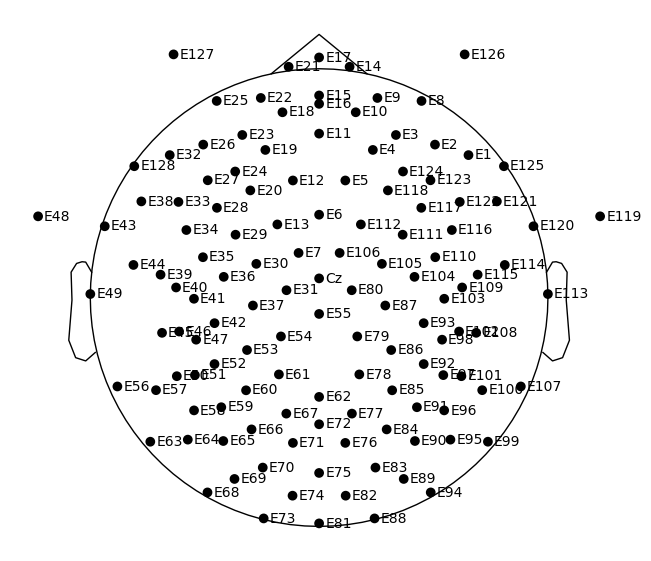

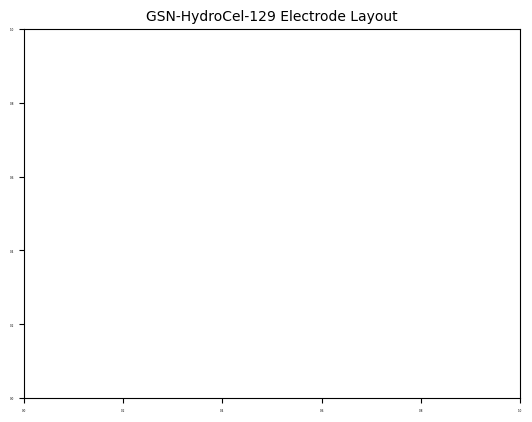

In [72]:
# === Visualize GHW ====

# Load the standard 129-channel HydroCel montage
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")

# Create a dummy Raw object just to visualize the layout
info = mne.create_info(ch_names=montage.ch_names, sfreq=1000, ch_types="eeg")
raw = mne.io.RawArray(data=np.zeros((len(montage.ch_names), 1)), info=info)
raw.set_montage(montage)

# Plot the layout with small font size
fig = raw.plot_sensors(show_names=True, kind='topomap')
plt.title("GSN-HydroCel-129 Electrode Layout", fontsize=10)
plt.tick_params(labelsize=2)
for text in fig.axes[0].texts:
    text.set_fontsize(6)
plt.show()
